In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../lib/src/')
import torch
import numpy as np
from torch import nn
import os
from matplotlib import pyplot as plt
import lightning as L
from sklearn.decomposition import PCA

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

%reload_ext autoreload
%autoreload 2

In [2]:
# Load the data
train_data = torch.load('ADNI_train.pt') #(N, T, D)
eval_data = torch.load('ADNI_eval.pt')
test_data = torch.load('ADNI_test.pt')
print(train_data.shape)

train_seq_mask = torch.load('ADNI_train_seq_mask.pt') #(N, T)
eval_seq_mask = torch.load('ADNI_eval_seq_mask.pt')
test_seq_mask = torch.load('ADNI_test_seq_mask.pt')

#Keeping only last observations when available
train_data = train_data[train_seq_mask[:, -1] == 1, -1] 
eval_data = eval_data[eval_seq_mask[:, -1] == 1, -1]
test_data = test_data[test_seq_mask[:, -1] == 1, -1]

print(train_data.shape)

torch.Size([8000, 8, 120])
torch.Size([3200, 120])


In [4]:
input_dim = (1, 120)
f = 40 #subsampling factor
latent_dim = 1* (input_dim[1] // f) * (input_dim[1] // f)
print('Latent dim:', latent_dim)

device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-09-15_13-56-13/final_model').to(device)
vae.eval()


Latent dim: 9


VAE(
  (decoder): Decoder_ADNI(
    (fc): Sequential(
      (0): Linear(in_features=9, out_features=15, bias=True)
      (1): ReLU()
      (2): Linear(in_features=15, out_features=30, bias=True)
      (3): ReLU()
      (4): Linear(in_features=30, out_features=60, bias=True)
      (5): ReLU()
      (6): Linear(in_features=60, out_features=120, bias=True)
      (7): Sigmoid()
    )
  )
  (encoder): Encoder_ADNI(
    (fc): Sequential(
      (0): Linear(in_features=120, out_features=60, bias=True)
      (1): ReLU()
      (2): Linear(in_features=60, out_features=30, bias=True)
      (3): ReLU()
      (4): Linear(in_features=30, out_features=15, bias=True)
      (5): ReLU()
    )
    (embedding): Linear(in_features=15, out_features=9, bias=True)
    (log_var): Linear(in_features=15, out_features=9, bias=True)
  )
)

In [5]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

in_channels = 1
out_channels = 1
channels = 32
n_res_blocks = 2
attention_levels = [0]
channel_multipliers = [1]
n_heads = 2

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

h, w = 120//f, 120//f


z = torch.randn(128, 1, h, w)
print("Shape of input U-NET: ", z.shape)
empty_prompt_embed = None
print("Shape of output: ", unet(z, torch.tensor([10]), empty_prompt_embed).shape)
print("Number of trainable params: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.0012


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)

Shape of input U-NET:  torch.Size([128, 1, 3, 3])
Shape of output:  torch.Size([128, 1, 3, 3])
Number of trainable params:  353953


In [ ]:
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 5*1e-6
BATCH_SIZE = 128
MAX_EPOCHS = 50

vae = vae.to('cuda')
latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end, channels = 1)
model = LitLDM(ldm = latent_diffusion, vae = vae, lr = lr, channels = 1).to('cuda')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)

trainer.fit(model, train_loader, val_loader)

#model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

In [ ]:
vae = vae.to('cuda')
model = model.to('cuda')
trainer = L.Trainer()
trainer.validate(model, val_loader)
trainer.validate(model, train_loader)

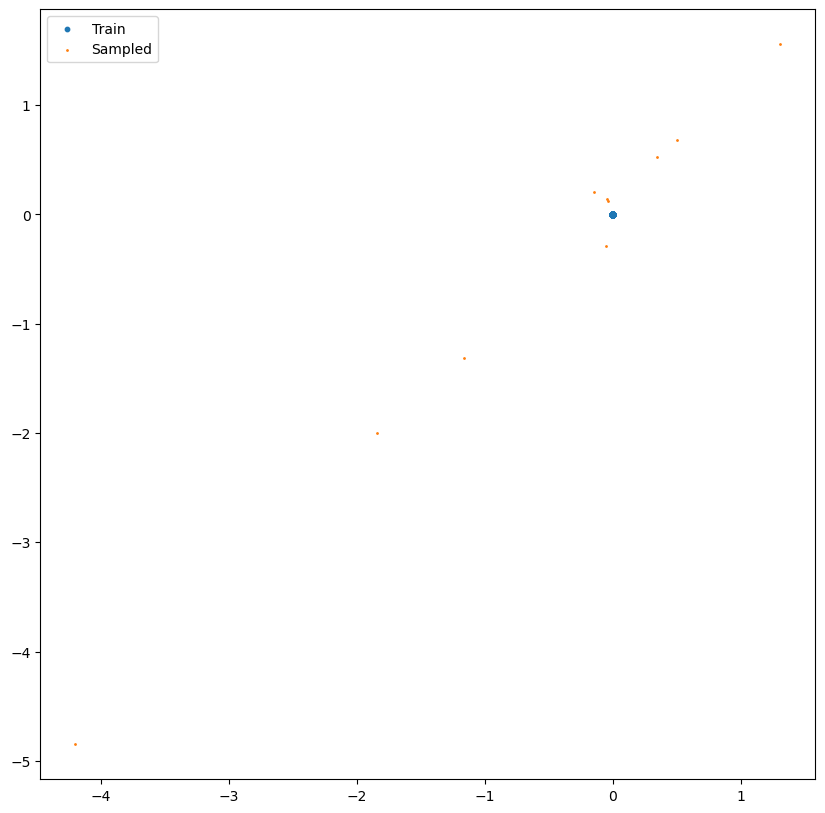

In [8]:
NUM_POINTS = 10
sampler = DDIMSampler(model.ldm, n_steps = 6, ddim_eta  = 1)
train_embeddings = vae.encoder.to('cpu')(train_data.data).embedding
start = torch.randn(NUM_POINTS, model.c, model.h, model.w).to('cpu')
z, all_z, all_pred_z0 = sampler.sample(shape=(NUM_POINTS, model.c, model.h, model.w), x_last = start, cond=None, temperature=0)

z = z.reshape(-1, latent_dim).float()
start = start.reshape(-1, latent_dim).float()

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())
z_pca = pca.transform(z.detach().numpy())
start_pca = pca.transform(start.detach().numpy())


plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], s=10, label = "Train")
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=1, label = "Sampled")

#plt.scatter(start_pca[:, 0], start_pca[:, 1], s=10, label = "Start")
plt.legend()
plt.show()
